In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../..')

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

In [6]:
import deepmatcher as dm
from utils.intermediate_layer_extraction import return_layer_input
from utils.ri_calculator import aggregateRi
from utils.explainer import Explainer
from utils.distance_measures import nearestNeighborOnAttributes
import pandas as pd
import torch
import copy 

In [4]:
attributes = ['Song_Name','Artist_Name','Album_Name','Genre','Price','CopyRight','Time','Released']

## Hybrid

### Datasets creation

In [5]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model.load_state('../../models/itunes_amazon_hybrid.pth')
hybrid_model = hybrid_model.to('cuda')

In [8]:
negatives = return_layer_input(hybrid_model,hybrid_model.classifier,'../../datasets/Structured/itunes-amazon',
                               'negatives',0)

In [9]:
positives = return_layer_input(hybrid_model,hybrid_model.classifier,
                               '../../datasets/Structured/itunes-amazon','positives',1)

### Negative sample analysis

In [11]:
attribute_len = int(len(list(positives.values())[0])/len(attributes))
DATASET_DIR = '../../datasets/Structured/itunes-amazon/'

In [7]:
explainer = Explainer(hybrid_model,attributes)

In [13]:
testneg_ri,testneg_ri_agg,testneg = explainer.getRankingsWhiteBox(DATASET_DIR,'test_negatives',0,'cosine')

Computing vectors in the classifier space


100%|██████████| 73/73 [00:18<00:00,  4.04it/s]


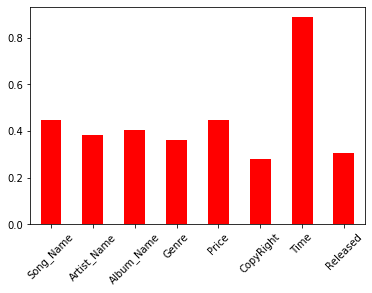

In [24]:
plt = testneg_ri_agg.drop(['sample_id'],axis=1).mean().plot.bar(color='red',rot=45)

In [25]:
fig = plt.get_figure()
fig.savefig('testneg_ri.png',dpi=300,bbox_inches='tight')

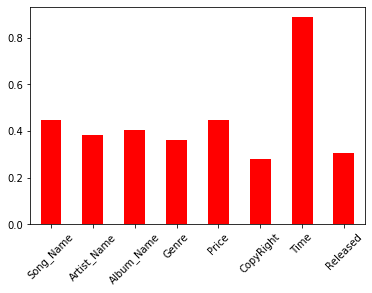

In [13]:
aggregateRi(testneg_ri,testneg,attributes,attribute_len,aggregation_type='cosine').mean().plot.bar(
    color='red',rot=45)

In [15]:
torch.save(testneg_ri,'experiments/results/testneg_ri_hybrid.pt')
neg_ri_norms.to_csv('experiments/results/testneg_ri_norms.csv',index=False)

## Positive samples analisys

In [16]:
testpos_ri,testpos_ri_norms = computeRi(hybrid_model.classifier,attributes,
                                              testpos,1,aggregation_type='euclide')

100%|██████████| 24/24 [00:08<00:00,  2.86it/s]


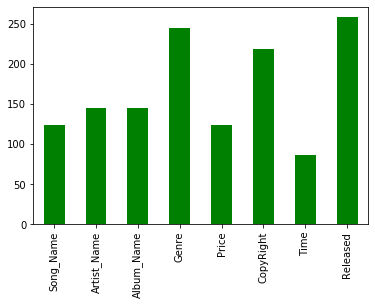

In [19]:
testpos_ri_norms.drop(['sample_id'],axis=1).sum().plot.bar(color='green')

In [20]:
torch.save(testpos_ri,'experiments/results/testpos_ri_hybrid.pt')
testpos_ri_norms.to_csv('experiments/results/testpos_ri_norms.csv',index=False)

## Nearest neighbors hybrid

In [21]:
testpos_ri = torch.load('experiments/results/testpos_ri_hybrid.pt')
testneg_ri = torch.load('experiments/results/testneg_ri_hybrid.pt')

In [22]:
attribute_len = int(len(list(testpos.values())[0])/len(attributes))

In [23]:
positives_nn_hybrid = nearestNeighborOnAttributes(testpos,testpos_ri,
                                                       negatives,attributes,attribute_len,
                                                               min_similarity=-1)

100%|██████████| 24/24 [00:00<00:00, 167.57it/s]


In [24]:
negatives_nn_hybrid = nearestNeighborOnAttributes(testneg,testneg_ri,
                                                        positives,attributes,attribute_len,
                                                               min_similarity=-1)

100%|██████████| 73/73 [00:00<00:00, 230.13it/s]


In [25]:
positives_nn_hybrid.to_csv('experiments/results/testposNN_hybrid.csv',index=False)
negatives_nn_hybrid.to_csv('experiments/results/testnegNN_hybrid.csv',index=False)

## Nearest neighbors distances
The distances are useful to correct rankings

In [27]:
from utils.distance_measures import smallestDistanceOnAttributes,correctRankings

In [28]:
neg_ri_norms = pd.read_csv('experiments/results/testneg_ri_norms.csv')
pos_ri_norms = pd.read_csv('experiments/results/testpos_ri_norms.csv')
testpos_ri = torch.load('experiments/results/testpos_ri_hybrid.pt')
testneg_ri = torch.load('experiments/results/testneg_ri_hybrid.pt')

In [35]:
testpos_nn_distances = smallestDistanceOnAttributes(testpos,testpos_ri,
                                                       negatives,attributes,attribute_len,distance_type='euclidean')

100%|██████████| 24/24 [00:00<00:00, 339.21it/s]


In [36]:
ext_negatives = return_layer_input(hybrid_model,hybrid_model.classifier,'../../datasets/Structured/itunes-amazon',
                               'extended_negatives')

TypeError: return_layer_input() missing 1 required positional argument: 'trueLabel'

In [ ]:
testpos_nn_distances_ext = smallestDistanceOnAttributes(testpos,testpos_ri,
                                                       ext_negatives,attributes,attribute_len,distance_type='euclidean')

In [ ]:
testpos_nn_distances_ext.mean()

In [37]:
testneg_nn_distances = smallestDistanceOnAttributes(testneg,testneg_ri,
                                                        positives,attributes,attribute_len,distance_type='euclidean')

100%|██████████| 73/73 [00:00<00:00, 448.31it/s]


In [40]:
correct_rankings_testpos = correctRankings(testpos_ri_norms,testpos_nn_distances)
correct_rankings_testneg = correctRankings(neg_ri_norms,testneg_nn_distances)

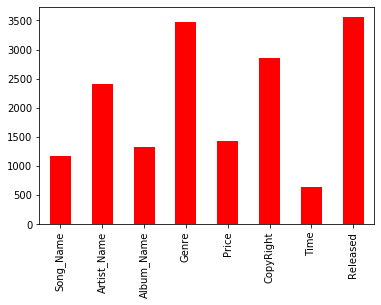

In [41]:
correct_rankings_testneg.drop(['sample_id'],axis=1).sum().plot.bar(color='red')

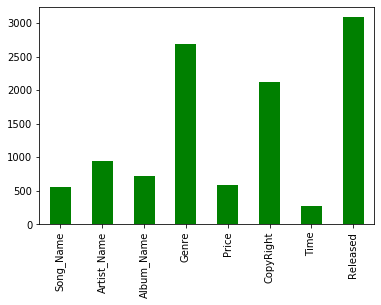

In [42]:
correct_rankings_testpos.drop(['sample_id'],axis=1).sum().plot.bar(color='green')